<a href="https://colab.research.google.com/github/SasmithaDilshan/Machine-Learning/blob/main/Machine_Vision_%20Oxford-IIIT%20Pet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
(ds_train, ds_val,ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:90%]','train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIQ4H9L/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIQ4H9L/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


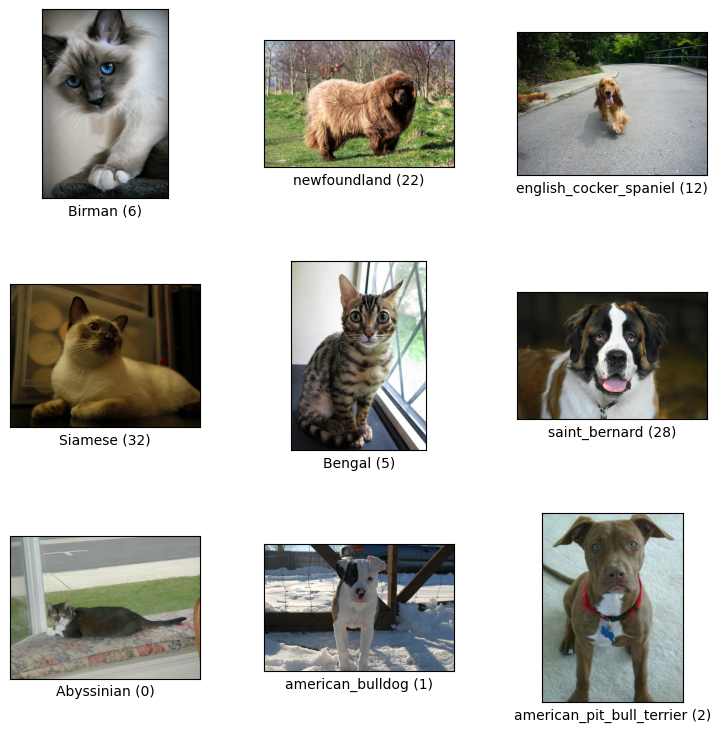

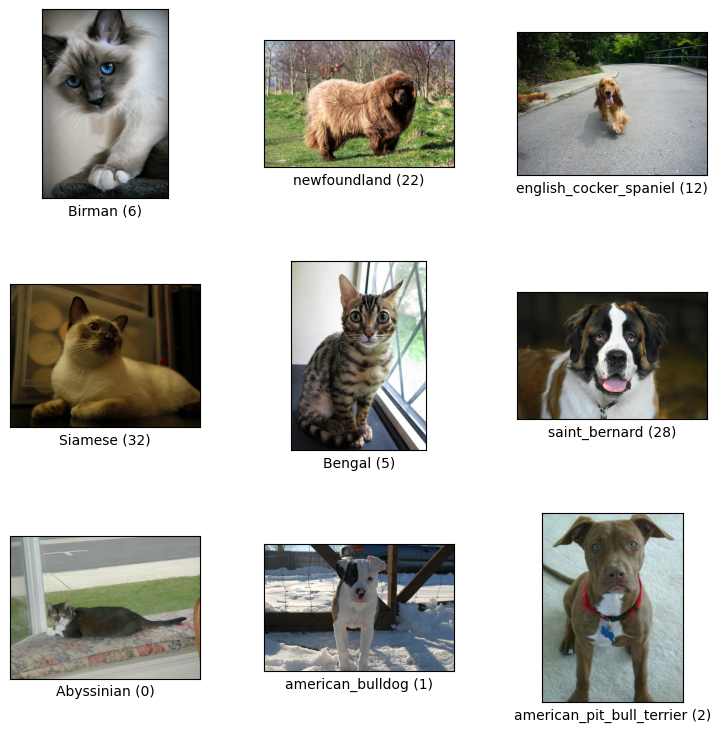

In [3]:
tfds.show_examples(ds_train, ds_info, image_key='image',label_key = 'label')

In [4]:
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)


Number of classes: 37


In [5]:
num_train_examples = tf.data.experimental.cardinality(ds_train).numpy()
num_val_examples = tf.data.experimental.cardinality(ds_val).numpy()
num_test_examples = tf.data.experimental.cardinality(ds_test).numpy()

print('Number of training samples:', num_train_examples)
print('Number of val samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 3312
Number of val samples: 368
Number of test samples: 3669


In [6]:
get_label = ds_info.features['label'].int2str

In [7]:
print(get_label(21))

miniature_pinscher


In [8]:
def view_single_image(ds):
    image, label = next(iter(ds))
    print(label)
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label(label))

tf.Tensor(21, shape=(), dtype=int64)
Image shape:  (333, 500, 3)


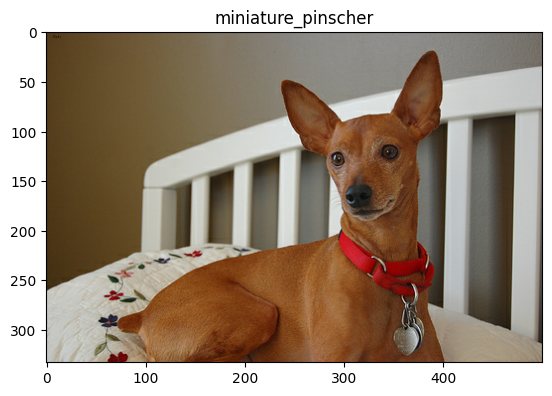

In [9]:
view_single_image(ds_train)

In [10]:
IMG_SIZE = 224

train_ds = ds_train.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = ds_val.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = ds_test.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [11]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [13]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
    #  layers.RandomRotation(factor=(-0.025, 0.025)),
    #  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #  layers.RandomContrast(factor=0.1),
     ])


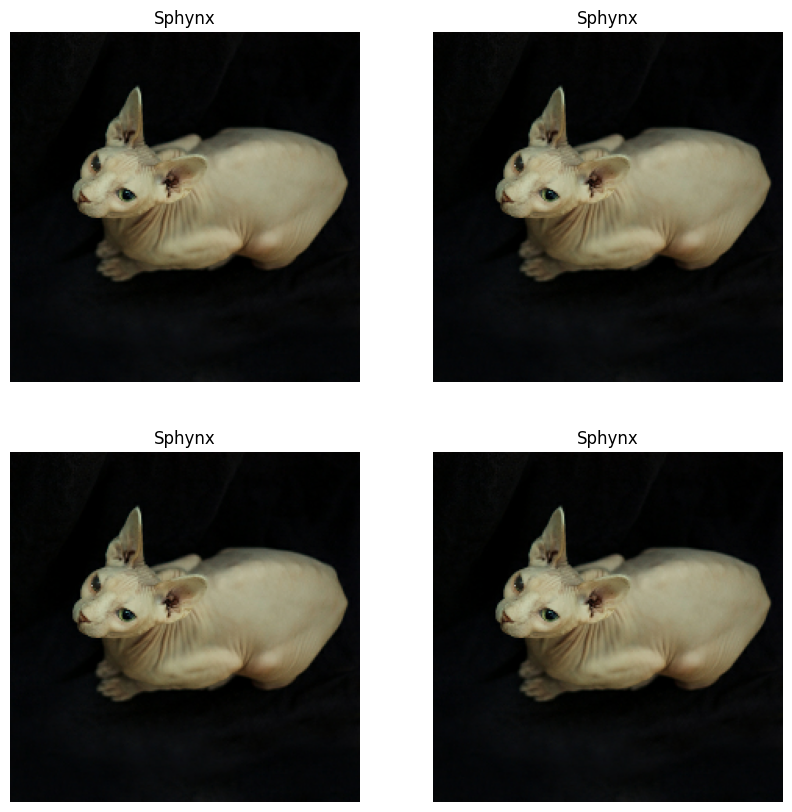

In [14]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        plt.imshow(image.numpy().astype("uint8"))

        plt.title(get_label(np.argmax(label)))
        plt.axis("off")

In [15]:
BATCH_SIZE = 32

In [16]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)


In [17]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3),pooling="avg"
                            )

94668760/94668760 [==============================] - 1s 0us/step


In [18]:
# Freeze the base_model
base_model.trainable = False

In [19]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = (inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)



model = keras.Model(inputs, outputs)

In [20]:
# model.summary()

In [21]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2048)


In [22]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [23]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [26]:
EPOCHS = 10

history = model.fit(train_ds, epochs=EPOCHS,validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/10
103/103 [==============================] - 18s 175ms/step - loss: 0.0737 - categorical_accuracy: 0.9900 - val_loss: 0.4106 - val_categorical_accuracy: 0.8580
Epoch 2/10
103/103 [==============================] - 14s 131ms/step - loss: 0.0615 - categorical_accuracy: 0.9912 - val_loss: 0.4222 - val_categorical_accuracy: 0.8608
Epoch 3/10
103/103 [==============================] - 14s 131ms/step - loss: 0.0581 - categorical_accuracy: 0.9894 - val_loss: 0.4120 - val_categorical_accuracy: 0.8636
Epoch 4/10
103/103 [==============================] - 14s 131ms/step - loss: 0.0464 - categorical_accuracy: 0.9942 - val_loss: 0.4189 - val_categorical_accuracy: 0.8580
Epoch 5/10
103/103 [==============================] - 14s 131ms/step - loss: 0.0375 - categorical_accuracy: 0.9958 - val_loss: 0.4408 - val_categorical_accuracy: 0.8580
Epoch 6/10
103/103 [==============================] - 14s 139ms/step - loss: 0.0325 - categorical_accuracy: 0.9973 - val_loss: 0.4325 - val_categorical_acc

Predictions:
 [[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


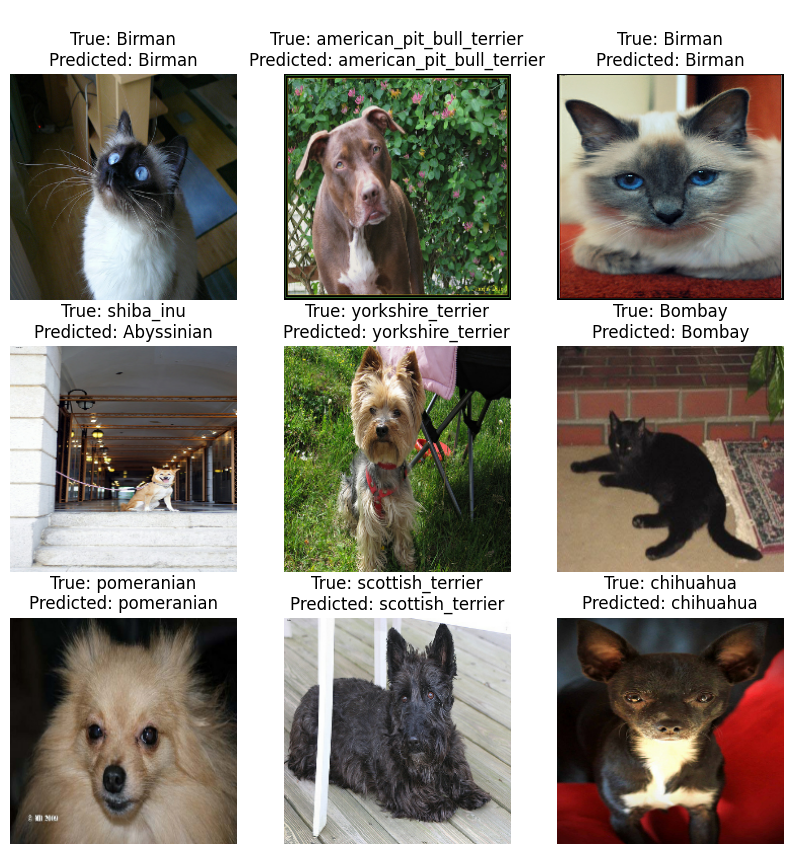

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"\nTrue: {get_label(np.argmax(label_batch[i]))}\nPredicted: {get_label(np.argmax(predictions[i]))}")
  plt.axis("off")